In [28]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn import tree
from sklearn import metrics
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

In [2]:
path = "/Users/zachgarberman/Desktop/Applied ML/Project Data/"
df = pd.read_csv(path + 'chicago_df.csv')

One-Hot Encode, Test/Train Split

In [3]:
description_oh = pd.get_dummies(df['description'], drop_first = True)
weekday_oh = pd.get_dummies(df['dayofweek'], drop_first = True)
month_oh = pd.get_dummies(df['month'], drop_first = True, prefix="Month")
df_2 = pd.concat([df,description_oh,weekday_oh,month_oh],axis = 1)
df_2 = df_2.drop(['description','dayofweek','month'],axis=1)

In [4]:
X = df_2.iloc[:,2:]
y = df_2.iloc[:,0:1]

In [5]:
X_train = X.iloc[0:int(0.70*len(X)),]
y_train = y.iloc[0:int(0.70*len(X)),]
X_test = X.iloc[int(0.70*len(X)):,]
y_test = y.iloc[int(0.70*len(X)):,]

Linear Regression

In [6]:
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression()

In [7]:
m1,n1 = y_test.shape
m2,n2 = y_train.shape
y_test_pred = reg.predict(X_test).reshape((m1,n1))
y_train_pred = reg.predict(X_train).reshape((m2,n2))
SSR = np.sum((y_test.to_numpy() - y_test_pred)**2)
train_mean = np.mean(y_train.to_numpy())
SST = np.sum((train_mean - y_test_pred)**2)
OSR2 = 1 - (SSR/SST)
print("IS-R^2:",metrics.r2_score(y_train.to_numpy(),y_train_pred))
print("OS-R^2:",OSR2)
print("IS-MAE:",metrics.mean_absolute_error(y_train,y_train_pred))
print("OS-MAE:",metrics.mean_absolute_error(y_test,y_test_pred))
print("IS-MSE:",metrics.mean_squared_error(y_train,y_train_pred))
print("OS-MSE:",metrics.mean_squared_error(y_test,y_test_pred))

IS-R^2: 0.6754647783701148
OS-R^2: 0.4528258298887585
IS-MAE: 903.784127476423
OS-MAE: 1058.417216818175
IS-MSE: 1394712.4914335045
OS-MSE: 1981708.5217724806


Cross-Validated Ridge Regression

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)
ridge_train = pd.DataFrame(scaler.transform(X_train))
ridge_test = pd.DataFrame(scaler.transform(X_test))

In [12]:
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(ridge_train):
    X_tr, X_val = ridge_train.iloc[tr_index,:], ridge_train.iloc[val_index,:]
    y_tr, y_val = y_train.iloc[tr_index,:], y_train.iloc[val_index,:]
    for penalty in [10,5,2,1,0.1,0.01]:
        ridge = Ridge(alpha=penalty)
        ridge.fit(X_tr, y_tr)
        m,n = y_val.shape
        y_val_pred = ridge.predict(X_val).reshape((m,n))
        SSR = np.sum((y_val.to_numpy() - y_val_pred)**2)
        train_mean = np.mean(y_tr.to_numpy())
        SST = np.sum((train_mean - y_val_pred)**2)
        OSR2 = 1 - (SSR/SST)
        score.append([i,
                      penalty,
                      OSR2])
    i += 1

In [13]:
score = pd.DataFrame(score).rename(columns={0: "Iteration", 1: "Lambda",2:"OSR2"})
cross_val = score.groupby(['Lambda']).agg({'OSR2':'mean'}).reset_index()
print(cross_val[cross_val.OSR2 == cross_val.OSR2.max()])

   Lambda      OSR2
0    0.01  0.432875


In [14]:
ridge_cv = Ridge(alpha=0.01).fit(ridge_train, y_train)
m1,n1 = y_test.shape
m2,n2 = y_train.shape
y_test_pred = ridge_cv.predict(ridge_test).reshape((m1,n1))
y_train_pred = ridge_cv.predict(ridge_train).reshape((m2,n2))
SSR = np.sum((y_test.to_numpy() - y_test_pred)**2)
train_mean = np.mean(y_train.to_numpy())
SST = np.sum((train_mean - y_test_pred)**2)
OSR2 = 1 - (SSR/SST)
print("IS-R^2:",metrics.r2_score(y_train.to_numpy(),y_train_pred))
print("OS-R^2:",OSR2)
print("IS-MAE:",metrics.mean_absolute_error(y_train,y_train_pred))
print("OS-MAE:",metrics.mean_absolute_error(y_test,y_test_pred))
print("IS-MSE:",metrics.mean_squared_error(y_train,y_train_pred))
print("OS-MSE:",metrics.mean_squared_error(y_test,y_test_pred))

IS-R^2: 0.6754647783693333
OS-R^2: 0.4528253009092639
IS-MAE: 903.7840896710281
OS-MAE: 1058.4171879519772
IS-MSE: 1394712.4914368629
OS-MSE: 1981708.7437899027


Cross-Validated CART

In [97]:
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[tr_index,:], X_train.iloc[val_index,:]
    y_tr, y_val = y_train.iloc[tr_index,:], y_train.iloc[val_index,:]
    for md in [2,4,6,8,10]:
        for mb in [100,150,200]:
            for alpha in [100,10,1,0.1]:
                cart = DecisionTreeRegressor(
                    max_depth=md,
                    min_samples_leaf=mb,
                    criterion = "mse",
                    ccp_alpha = alpha)
                cart.fit(X_tr, y_tr)
                m,n = y_val.shape
                y_val_pred = cart.predict(X_val).reshape((m,n))
                SSR = np.sum((y_val.to_numpy() - y_val_pred)**2)
                train_mean = np.mean(y_tr.to_numpy())
                SST = np.sum((train_mean - y_val_pred)**2)
                OSR2 = 1 - (SSR/SST)
                score.append([i,
                            md,
                            mb,
                            alpha, 
                            OSR2])
    i += 1

In [98]:
score = pd.DataFrame(score).rename(columns={0: "Iteration", 1: "Depth",2:"MinBucket", 3:"Alpha", 4:"OSR2"})
cross_val = score.groupby(['Depth','Alpha','MinBucket']).agg({'OSR2':'mean'}).reset_index()
print(cross_val[cross_val.OSR2 == cross_val.OSR2.max()])

    Depth  Alpha  MinBucket      OSR2
48     10    0.1        100  0.512091
51     10    1.0        100  0.512091
54     10   10.0        100  0.512091


In [15]:
cart_cv = DecisionTreeRegressor(max_depth=10,min_samples_leaf=100,ccp_alpha=10).fit(X_train, y_train)
m1,n1 = y_test.shape
m2,n2 = y_train.shape
y_test_pred = cart_cv.predict(X_test).reshape((m1,n1))
y_train_pred = cart_cv.predict(X_train).reshape((m2,n2))
SSR = np.sum((y_test.to_numpy() - y_test_pred)**2)
train_mean = np.mean(y_train.to_numpy())
SST = np.sum((train_mean - y_test_pred)**2)
OSR2 = 1 - (SSR/SST)
print("IS-R^2:",metrics.r2_score(y_train.to_numpy(),y_train_pred))
print("OS-R^2:",OSR2)
print("IS-MAE:",metrics.mean_absolute_error(y_train,y_train_pred))
print("OS-MAE:",metrics.mean_absolute_error(y_test,y_test_pred))
print("IS-MSE:",metrics.mean_squared_error(y_train,y_train_pred))
print("OS-MSE:",metrics.mean_squared_error(y_test,y_test_pred))

IS-R^2: 0.8509216798765165
OS-R^2: 0.7997954708155872
IS-MAE: 548.0030996610357
OS-MAE: 687.7669774648791
IS-MSE: 640674.3595777359
OS-MSE: 1009089.794934767


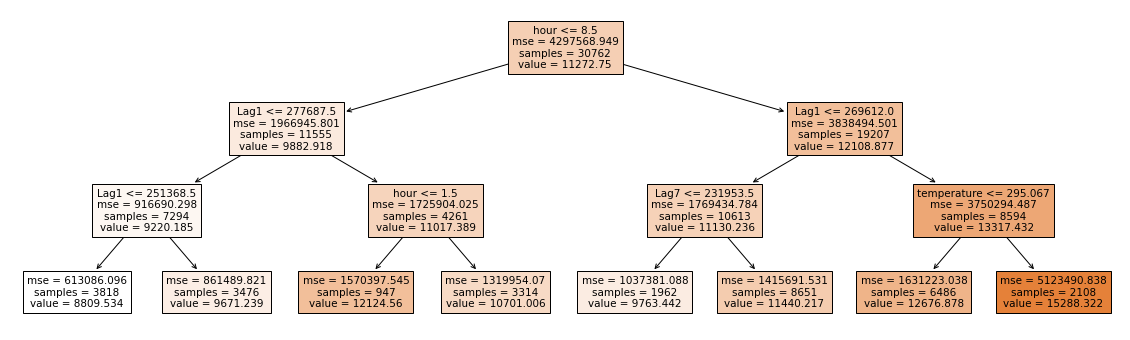

In [23]:
features = [i for i in X_test.columns]
cart_plot = DecisionTreeRegressor(max_depth=3,min_samples_leaf=100,ccp_alpha=10).fit(X_train, y_train)
plt.figure(figsize=(20, 6))
tree.plot_tree(cart_plot, filled=True,feature_names=features)
plt.show()

Cross-Validated Gradient Boosted Trees

In [17]:
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[tr_index,:], X_train.iloc[val_index,:]
    y_tr, y_val = y_train.iloc[tr_index,:], y_train.iloc[val_index,:]
    for lr in [0.1,0.01,0.001]:
        for trees in [50,100,150]:
            for md in [3,5,7]:
                for features in ["auto","sqrt","log2"]:
                    gbm = GradientBoostingRegressor(
                        learning_rate=lr,
                        n_estimators=trees,
                        max_depth=md,
                        max_features=features)
                    gbm.fit(X_tr, np.ravel(y_tr))
                    m,n = y_val.shape
                    y_val_pred = gbm.predict(X_val).reshape((m,n))
                    SSR = np.sum((y_val.to_numpy() - y_val_pred)**2)
                    train_mean = np.mean(y_tr.to_numpy())
                    SST = np.sum((train_mean - y_val_pred)**2)
                    OSR2 = 1 - (SSR/SST)
                    score.append([i,
                                lr,
                                trees,
                                md, 
                                features,
                                OSR2])
    i += 1

In [18]:
score = pd.DataFrame(score).rename(columns={0: "Iteration", 1: "LearningRate",2:"Trees", 
                                            3:"Depth", 4:"Features", 5:"OSR2"})
cross_val = score.groupby(['LearningRate','Trees','Depth','Features']).agg({'OSR2':'mean'}).reset_index()
print(cross_val[cross_val.OSR2 == cross_val.OSR2.max()])

    LearningRate  Trees  Depth Features      OSR2
72           0.1    150      3     auto  0.654229


In [19]:
gbm_cv = GradientBoostingRegressor(learning_rate=0.1, n_estimators=150, max_depth=3, 
                                max_features='auto').fit(X_train, np.ravel(y_train))
m1,n1 = y_test.shape
m2,n2 = y_train.shape
y_test_pred = gbm_cv.predict(X_test).reshape((m1,n1))
y_train_pred = gbm_cv.predict(X_train).reshape((m2,n2))
SSR = np.sum((y_test.to_numpy() - y_test_pred)**2)
train_mean = np.mean(y_train.to_numpy())
SST = np.sum((train_mean - y_test_pred)**2)
OSR2 = 1 - (SSR/SST)
print("IS-R^2:",metrics.r2_score(y_train.to_numpy(),y_train_pred))
print("OS-R^2:",OSR2)
print("IS-MAE:",metrics.mean_absolute_error(y_train,y_train_pred))
print("OS-MAE:",metrics.mean_absolute_error(y_test,y_test_pred))
print("IS-MSE:",metrics.mean_squared_error(y_train,y_train_pred))
print("OS-MSE:",metrics.mean_squared_error(y_test,y_test_pred))

IS-R^2: 0.9096533617573482
OS-R^2: 0.8803278894609147
IS-MAE: 434.2064011733681
OS-MAE: 520.2508547846007
IS-MSE: 388270.9071860163
OS-MSE: 581430.3771932785


In [32]:
sorted_idx.size

63

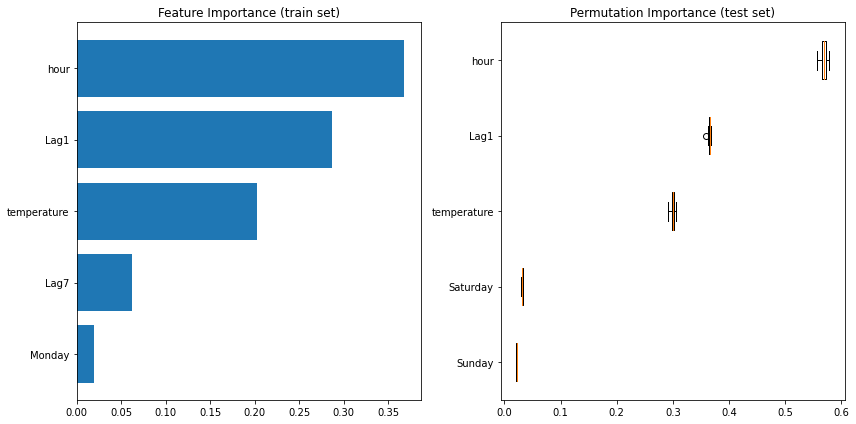

In [42]:
feature_importance = gbm_cv.feature_importances_
sorted_idx = np.argsort(feature_importance)[58:63]
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance (train set)')

result = permutation_importance(gbm_cv, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()[58:63]
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_test.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

Cross-Validated Random Forest

In [43]:
tscv = TimeSeriesSplit(n_splits=5)
i = 1
score = []
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[tr_index,:], X_train.iloc[val_index,:]
    y_tr, y_val = y_train.iloc[tr_index,:], y_train.iloc[val_index,:]
    for mb in [100,150,200]:
        for trees in [50,100,150]:
            for md in [2,4,6,8,10]:
                for features in ["auto","sqrt","log2"]:
                    rf = RandomForestRegressor(
                        min_samples_leaf=mb,
                        n_estimators=trees,
                        max_depth=md,
                        max_features=features)
                    rf.fit(X_tr, np.ravel(y_tr))
                    m,n = y_val.shape
                    y_val_pred = rf.predict(X_val).reshape((m,n))
                    SSR = np.sum((y_val.to_numpy() - y_val_pred)**2)
                    train_mean = np.mean(y_tr.to_numpy())
                    SST = np.sum((train_mean - y_val_pred)**2)
                    OSR2 = 1 - (SSR/SST)
                    score.append([i,
                                mb,
                                trees,
                                md, 
                                features,
                                OSR2])
    i += 1

In [44]:
score = pd.DataFrame(score).rename(columns={0: "Iteration", 1: "MinBucket",2:"Trees", 
                                            3:"Depth", 4:"Features", 5:"OSR2"})
cross_val = score.groupby(['MinBucket','Trees','Depth','Features']).agg({'OSR2':'mean'}).reset_index()
print(cross_val[cross_val.OSR2 == cross_val.OSR2.max()])

    MinBucket  Trees  Depth Features      OSR2
42        100    150     10     auto  0.441631


In [46]:
rf_cv = RandomForestRegressor(min_samples_leaf=100, n_estimators=150, max_depth=10, 
                                max_features='auto').fit(X_train, np.ravel(y_train))
m1,n1 = y_test.shape
m2,n2 = y_train.shape
y_test_pred = rf_cv.predict(X_test).reshape((m1,n1))
y_train_pred = rf_cv.predict(X_train).reshape((m2,n2))
SSR = np.sum((y_test.to_numpy() - y_test_pred)**2)
train_mean = np.mean(y_train.to_numpy())
SST = np.sum((train_mean - y_test_pred)**2)
OSR2 = 1 - (SSR/SST)
print("IS-R^2:",metrics.r2_score(y_train.to_numpy(),y_train_pred))
print("OS-R^2:",OSR2)
print("IS-MAE:",metrics.mean_absolute_error(y_train,y_train_pred))
print("OS-MAE:",metrics.mean_absolute_error(y_test,y_test_pred))
print("IS-MSE:",metrics.mean_squared_error(y_train,y_train_pred))
print("OS-MSE:",metrics.mean_squared_error(y_test,y_test_pred))

IS-R^2: 0.8583082753146543
OS-R^2: 0.8188999380811464
IS-MAE: 532.3085918171529
OS-MAE: 645.5339550941899
IS-MSE: 608929.9563816917
OS-MSE: 863448.8256866232


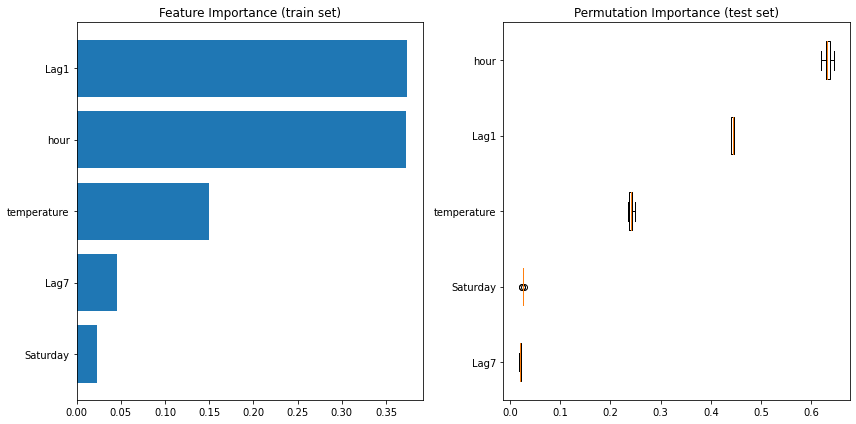

In [47]:
feature_importance = rf_cv.feature_importances_
sorted_idx = np.argsort(feature_importance)[58:63]
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance (train set)')

result = permutation_importance(rf_cv, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()[58:63]
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_test.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()